In [1]:
import xpress as xp
import pandas as pd
xp.controls.outputlog = 0

Using the license file found in your Xpress installation. If you want to use this license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/Applications/FICO Xpress/xpressmp/bin/xpauth.xpr')


## Problem narrative: Fleet retrofit and renewal over fixed time horizon with stepwise reduction of emissions

According to the Clydebank declaration, a "green corridor" is a zero-emission route between two ports. The realization of green corridors will most likely involve multiple stakeholders, including shipowners, cargo owners, fuel providers, ports, regulators, and will be financed both by private and public funding.

Here, we first consider a subset of the green corridor problem by finding the cost-minimum introduction of emission reduction options for a fixed fleet over a set of time periods with a stepwise reduction of the total emissions from the fleet.

## Problem outline

We consider a heterogenous fleet of vessels sailing between two ports or regions. The total capacity of the fleet is sufficient to transport the required annual volume. Each vessel has a current emission level. These emissions can be reduced by retrofits that gives a certain percentage reduction in emissions. The retrofits have both an investment cost that is due on the time period it is introduced, and a fixed operational cost each time period thereafter. The replacement of an exiting ship with a new one with the same annual capacity can also be modeled as a retrofit. The total emissions from the fleet must be below the emission target, $E_t$, and we assume a stepwise tightening of this target, \

#### Sets
<table align='left'>
<tr><td>$V$</td><td>The set of vessels in the fleet, indexed by $v$</td></tr>
<tr><td>$A$</td><td>The set of emission abatement options, indexed by $a$</td></tr>
<tr><td>$T$</td><td>The set of time period in the planning horizon, indexed by $t$</td></tr>
</table>

#### Parameters 

<table align='left'>
<tr><td>$E^V_v$</td><td>The emissions from vessel $v$ at the start of the planning period</td></tr> 
<tr><td>$\gamma_a$</td><td>The emission reduction effect of abatement option $a$</td></tr> 
<tr><td>$C^{AI}_{a}$</td><td>The installation cost of introducing abatement option $a$</td></tr>
<tr><td>$C^{AO}_{a}$</td><td>The annual operation cost of introducing abatement option $a$</td></tr>
<tr><td>$E^{TOT}_t$</td><td>Total allowed emissions for time period $t$</td></tr>
</table>

#### Variables

$x_{vat}$    1 if abatement option $a$ is being installed on vessel $v$ in time period $t$

$y_{vat}$    1 if abatement option $a$ is already installed on vessel $v$ in time period $t$

#### Model
<table align='left'>
<tr><td colspan=3>$$ min \sum_{v \in V} \sum_{a \in A}  \sum_{t \in T} (C^{AI}_{a} x_{vat} + C^{AO}_{a} y_{vat})$$</td></tr>
<tr><td align='left'>subject to</td></tr>
<tr><td>$$\sum_{v\in V} (E^V_v - \sum_{a\in A}\gamma_a E^V_v y_{vat}) \le E^{TOT}_t,$$</td><td>$$t\in T$$</td><td>(1)</td></tr> 
<tr><td>$$\sum_{t\in T}x_{vat}\le 1,$$</td><td>$$v\in V, a\in A$$</td><td>(2)</td></tr> 
<tr><td>$$M \sum_{t\in T}x_{vat}\ge \sum_{t\in T}y_{vat},$$</td><td>$$v\in V, a\in A$$</td><td>(3)</td></tr> 
<tr><td>$$y_{vat} \ge x_{va(t-1)},$$</td><td>$$v\in V, a\in A, t\in T/\{0\}$$</td><td>(4)</td></tr> 
<tr><td>$$y_{vat} \ge y_{va(t-1)},$$</td><td>$$v\in V, a\in A, t\in T/\{0\}$$</td><td>(5)</td></tr> 
<tr><td>$$y_{vat} - y_{va(t-1)} = x_{vat},$$</td><td>$$v\in V, a\in A, t\in T/\{0\}$$</td><td>(6)</td></tr> 
<tr><td>$$x_{vat} = 0$$</td><td>$$v\in V, a\in A, t=N^t$$</td><td>(7)</td></tr> 
<tr><td>$$x_{vat} \in \{0,1\},$$</td><td>$$v\in V, a\in A, t\in T$$</td><td>(8)</td></tr> 
<tr><td>$$y_{vat} \in \{0,1\},$$</td><td>$$v\in V, a\in A, t\in T$$</td><td>(9)</td></tr> 
</table>

#### Explanation of model

(1) The total emissions from the fleet for a particular year must be less than the total allowed<br>
(2) A specific emission abatement option can only be introduced once during the planning horizon<br>
(3) (Technical) Make sure that an abatement option is installed if it is used<br>
(4) The abatement option is put into use the same time period that it is installed<br>
(5) When installed and put into use, it will be used for the remaining time periods<br>
(6) Force x to 1 when y switches from 0 to 1<br>
(7) No abatement options in last time period (required from a technical period)<br>
(8,9) Binary constraints

In [14]:
# The xpress implementation of the model described above
def gc_fleet_model(dfV,dfA,dfT):
    
    nV = dfV.shape[0]    
    nA = dfA.shape[0]    
    nT = dfT.shape[0]

    V = [v for v in range(nV)]
    A = [a for a in range(nA)]
    T = [t for t in range(nT)]

    bigM = 1000

    p = xp.problem()

    x = {(v,a,t): xp.var (vartype = xp.binary, name='x{0}{1}{2}'.format (v,a,t)) for t in T for a in A for v in V}
    y = {(v,a,t): xp.var (vartype = xp.binary, name='y{0}{1}{2}'.format (v,a,t)) for t in T for a in A for v in V}
    p.addVariable(x,y)
    #m.addVariable(y)

    # Objective function
    totCost = xp.Sum(dfA.C_I[a]*x[v,a,t] + dfA.C_O[a]*y[v,a,t] for v in V for a in A for t in T)
    p.setObjective(totCost, sense = xp.minimize)

    # Contraints 1: Max total annual emissions
    c1 = [xp.Sum(dfV.E[v] - xp.Sum(dfA.Red[a]*dfV.E[v]*y[v,a,t] for a in A) for v in V) <= dfT.E_req[t] for t in T]

    # Constraints 2: One particular abatement option used only once for each vessel
    c2 = [xp.Sum(x[v,a,t] for t in T) <= 1 for a in A for v in V]

    # Constraints 3: We must ensure that at x is 1 if at least one y is 1
    c3 = [bigM * xp.Sum(x[v,a,t] for t in T) >= xp.Sum(y[v,a,t] for t in T) for a in A for v in V]

    # Constraint 4: Abatement option installation triggers option use indicator
    c4 = [y[v,a,t] >= x[v,a,t] for t in T for a in A for v in V]

    # Constraint 5: Once triggered, option use indicator should last remaining time horison
    c5 = [y[v,a,t] >= y[v,a,t-1] for t in T[1:] for a in A for v in V]

    # Constraint 6: Abatement option installation triggers option use indicator
    # When y switches from 0 to 1, this triggers x=1, else x=0
    c6 = [y[v,a,t] - y[v,a,(t-1)] == x[v,a,t] for t in T[1:] for a in A for v in V]
    
    # Constraint 7: Abatement option should not be installed in last period
    c7 = [x[v,a,t] == 0 for t in T[-1:] for a in A for v in V]

    p.addConstraint(c1,c2,c3,c4,c5,c6,c7)

    xp.controls.outputlog = 0
    p.solve()
    
    return p,x,y

In [15]:
# Datasets for testing the model
dfV = pd.DataFrame.from_dict({'name':['v1','v2','v3'], 'E':[100,100,100]})
dfA = pd.DataFrame.from_dict({'name':['a1','a2','a3'], 'Red':[0.3,0.5,1.0], 'C_I':[20,40,110], 'C_O':[3,4,5]})
dfT = pd.DataFrame.from_dict({'year':[0,1,2,3,4,5,6,7], 'E_req':[290,280,260,200,150,120,80,40]})

In [16]:
dfV

,name,E
0,v1,100
1,v2,100
2,v3,100


In [4]:
p,x,y = gc_fleet_model(dfV,dfA,dfT)

In [5]:
p.write ("problem1", "lp") # Write the model to file

In [6]:
def analyseSolution(p,x,y,dfV,dfA,dfT):
    V = [v for v in range(dfV.shape[0])]
    A = [a for a in range(dfA.shape[0])]
    T = [t for t in range(dfT.shape[0])]
    
    annualInvCost = [sum([dfA.C_I[a]*p.getSolution(x[v,a,t]) for a in A for v in V]) for t in T]
    annualOpCost = [sum([dfA.C_O[a]*p.getSolution(y[v,a,t]) for a in A for v in V]) for t in T]
    annualEmissions = [sum([dfV.E[v] - sum([dfA.Red[a]*dfV.E[v]*p.getSolution(y[v,a,t]) for a in A]) for v in V]) for t in T]
    
    dfRes = pd.DataFrame.from_dict({'year':T, 'C_I':annualInvCost, 'C_O':annualOpCost, 'E':annualEmissions, 'E_req':dfT.E_req})
    dfRes['C_TOT'] = dfRes.C_I + dfRes.C_O

    solX = [[[int(p.getSolution(x[v,a,t])) for t in T] for a in A] for v in V]
    solY = [[[int(p.getSolution(y[v,a,t])) for t in T] for a in A] for v in V]

    # Add textual description of abatement installations
    txt = [['{} {}'.format(dfA.name[a], dfV.name[v]) for a in A for v in V if solX[v][a][t] == 1]  for t in T]
    dfRes['Descr'] = txt
    
    return dfRes,solX, solY

In [7]:
dfRes, solX, solY = analyseSolution(p,x,y,dfV,dfA,dfT)
dfRes

,year,C_I,C_O,E,E_req,C_TOT,Descr
0,0,110.0,5.0,200.0,290,115.0,[a3 v2]
1,1,0.0,5.0,200.0,280,5.0,[]
2,2,0.0,5.0,200.0,260,5.0,[]
3,3,0.0,5.0,200.0,200,5.0,[]
4,4,40.0,9.0,150.0,150,49.0,[a2 v1]
5,5,20.0,12.0,120.0,120,32.0,[a1 v2]
6,6,60.0,19.0,40.0,80,79.0,"[a1 v3, a2 v3]"
7,7,0.0,19.0,40.0,40,19.0,[]


In [8]:
solX #For verifying x values in solution

[[[0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 1, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 1, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 1, 0],
  [0, 0, 0, 0, 0, 0, 1, 0],
  [0, 0, 0, 0, 0, 0, 0, 0]]]

In [9]:
solY # For veryfing y values in solution (to be consistent with x)

[[[0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 1, 1, 1, 1],
  [0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 1, 1, 1],
  [0, 0, 0, 0, 0, 0, 0, 0],
  [1, 1, 1, 1, 1, 1, 1, 1]],
 [[0, 0, 0, 0, 0, 0, 1, 1],
  [0, 0, 0, 0, 0, 0, 1, 1],
  [0, 0, 0, 0, 0, 0, 0, 0]]]

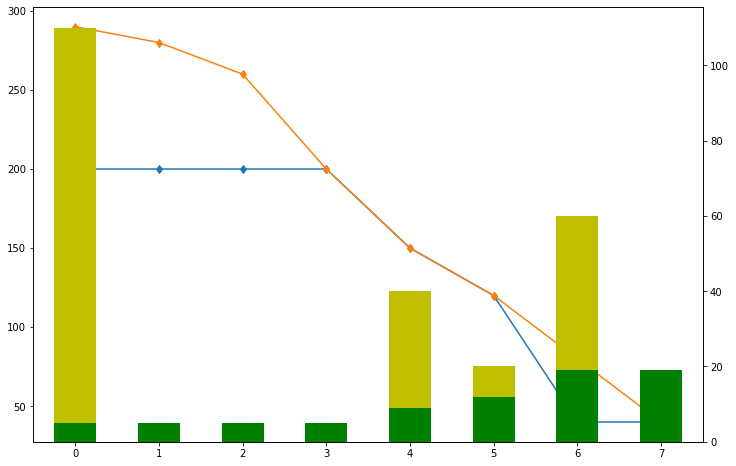

In [10]:
def plotRes(dfRes):
    import matplotlib.pyplot as plt

    # First, drop sum row if it is there
    if 'Sum' in dfRes.index:
        dfRes.drop(labels=['Sum'], axis=0, inplace=True)
    
    fig, ax1 = plt.subplots(figsize=(12, 8))
    dfRes.C_I.plot(kind='bar', color='y', stacked=False, secondary_y=True)
    dfRes.C_O.plot(kind='bar', color='g', stacked=False, secondary_y=True)
    dfRes.E.plot(kind='line', marker='d')
    dfRes.E_req.plot(kind='line', marker='d')

plotRes(dfRes)

In [11]:
#print('Status.: ', p.getProbStatusString())
#print('Sol.: ', p.getSolution())
#print('Dual: ', p.getDual())
#print('Obj. val.: ', p.getObjVal())
#print('Red. cost: ', p.getRCost())
#print('Slack: ', p.getSlack())

## A slightly larger problem

In [12]:
# Datasets for testing
nT = 10
nV = 10
dfV = pd.DataFrame.from_dict({'name':['Orias ' + str(v) for v in list(range(nV))], 'E':[100 for _ in list(range(nV))]})
dfA = pd.DataFrame.from_dict({'name':['WASP','Ammonia','Replace'], 'Red':[0.3,0.5,1.0], 'C_I':[40,40,110], 'C_O':[2,4,3]})
dfT = pd.DataFrame.from_dict({'year':list(range(nT)), 'E_req':[100*nT-70*t for t in range(nT)]})

In [19]:
p,x,y = gc_fleet_model(dfV,dfA,dfT)
dfRes, solX, solY = analyseSolution(p,x,y,dfV,dfA,dfT)
dfRes

,year,C_I,C_O,E,E_req,C_TOT,Descr
0,0,0.0,0.0,1000.0,1000,0.0,[]
1,1,110.0,3.0,900.0,930,113.0,[Replace Orias 4]
2,2,110.0,6.0,800.0,860,116.0,[Replace Orias 9]
3,3,40.0,8.0,770.0,790,48.0,[WASP Orias 9]
4,4,40.0,12.0,720.0,720,52.0,[Ammonia Orias 2]
5,5,80.0,20.0,620.0,650,100.0,"[Ammonia Orias 0, Ammonia Orias 3]"
6,6,40.0,24.0,570.0,580,64.0,[Ammonia Orias 8]
7,7,80.0,32.0,470.0,510,112.0,"[Ammonia Orias 1, Ammonia Orias 7]"
8,8,80.0,40.0,370.0,440,120.0,"[Ammonia Orias 5, Ammonia Orias 6]"
9,9,0.0,40.0,370.0,370,40.0,[]


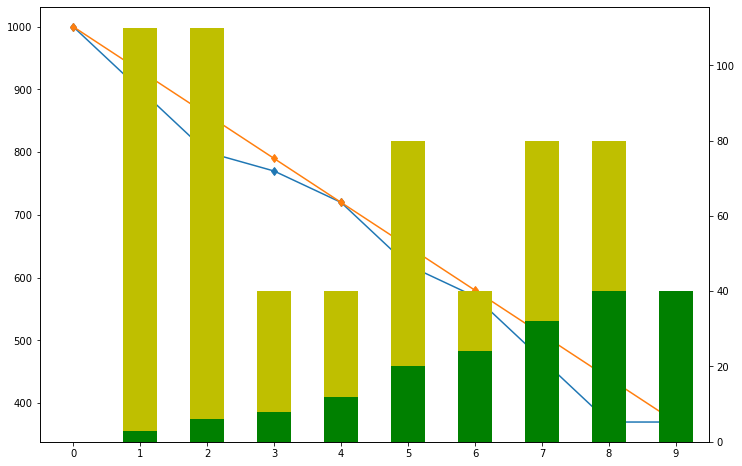

In [14]:
plotRes(dfRes)